In [1]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import json

In [2]:

def get_graph_paths(dataset_dir= "./datasets/"):
    graph_list = []
    for dirpath, _, files in os.walk(dataset_dir):
        for filename in files:
            try:
                if filename.endswith(".edges"):
                    file_path = os.path.join(dirpath, filename) 
                    graph_list.append((file_path, os.path.splitext(filename)[0]))
            except Exception as e: 
                print(e, f'{filename}')
    return graph_list


def get_sir_graph_paths(net_name, num_b=3,  result_path = './datasets/SIR_Results/'):
    paths= []
    for i in range(num_b):
        sir_dir =os.path.join(result_path, net_name)
        sir_dir = os.path.join(sir_dir, f'{i}.csv')
        paths.append(sir_dir)
    return paths


In [3]:

def SIR(G, infected, B_values, gama=1.0, num_iterations=100, num_steps=200):
    num_nodes = G.number_of_nodes()
    affected_scales = {}
    infected_scales = {}
    for B in B_values:
        recovered_sum = 0  # To store the sum of recovered nodes across all iterations
        infected_sum = 0

        # Store trends for plotting
        trends = []

        for i in range(num_iterations):
            # Initialize the SIR model
            model = ep.SIRModel(G)
            
            # Configuration setup
            config = mc.Configuration()
            config.add_model_parameter('beta', B)  # Set infection rate to current B
            config.add_model_parameter('gamma', gama)  # Recovery probability = 1
            # config.add_model_initial_configuration("Infected",  {0: 1})  # Start with node 0 infected
            config.add_model_initial_configuration("Infected",  infected)  
            
            # Set the model configuration
            model.set_initial_status(config)
            
            
            iteration = None
            # Run the model until all nodes are either recovered or susceptible
            for step in range(num_steps):  # Maximum 200 steps
                iteration = model.iteration()
                trends.append(model.build_trends([iteration]))
                
                # Check if all nodes are either recovered or susceptible (no infected nodes left)
                if iteration['node_count'][1] == 0:  # Index 1 corresponds to 'Infected'
                    break  # Exit the loop if no infected nodes remain

            # Get the final state after the infection spread
            final_state = iteration['node_count']
            recovered_nodes = final_state[2]  # Index 2 represents 'Recovered' nodes
            recovered_sum += recovered_nodes
            infected_sum += final_state[1]# Index 1 represents 'inffected' nodes
        
        # Calculate the affected scale for the current B
        affected_scale = recovered_sum / (num_iterations * num_nodes)
        affected_scales[B] = round(affected_scale, 6)
        infected_scales[B] = infected_sum 
    return affected_scales, infected_scales


In [4]:

def analyze_sir_vs_iterations(net_name, G, infected_nodes, B_values, gama, num_iterations_list, num_steps=200):
    execution_times = {str(num_iterations): [] for num_iterations in num_iterations_list}

    plt.figure(figsize=(10, 6))

    for node in infected_nodes:
        infected = {node: 1}
        average_sir_values = []

        for num_iterations in num_iterations_list:
            # Measure the start time
            start_time = time.time()

            # Run the SIR simulation
            affected_scales, _ = SIR(G, infected, B_values, gama, num_iterations, num_steps)
            
            # Measure the end time
            end_time = time.time()
            duration = end_time - start_time  # Duration in seconds

            # Save the execution time
            execution_times[str(num_iterations)].append(duration)

            average_sir_value = sum(affected_scales.values()) / len(B_values)
            average_sir_values.append(average_sir_value)

        plt.plot(num_iterations_list, average_sir_values, marker='o', label=f"Node {node}")

    plt.title(f"SIR Value over Iterations: {net_name}")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Average SIR Value")
    plt.legend()
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(f"./sir_labeling/images/iterations/sir_val_over_iter_{net_name}.png", dpi=300, bbox_inches='tight')

    plt.show()

    # Calculate average execution times for each num_iterations and return
    avg_execution_times = {num_iterations: round(np.mean(times), 2) for num_iterations, times in execution_times.items()}
    return avg_execution_times



def choose_random_node(G):
    return random.choice(list(G.nodes))


def get_B_Value(G, num_b=3):
    # Get the mean degree (k) of the graph
    degrees = [deg for _, deg in G.degree()]
    
    # First moment (mean degree)
    mean_degree = np.mean(degrees)

    # Second moment (mean of squared degrees)
    mean_degree_squared = np.mean([deg**2 for deg in degrees])

    # Epidemic threshold (B_Threshold)
    B_Threshold = mean_degree / (mean_degree_squared - mean_degree)
    # Range of B values
    B_values = np.linspace(1 * B_Threshold, 2 * B_Threshold, num_b)
    # Use numpy's round function
    B_values = np.round(B_values, 3)
    B_values = B_values.tolist()
    return B_values

# RESULTS

GOOD for showing why there was impovement from 100(previous run's results) and the 200 that the paper used:

ba_edgelist_1000_4

ba_edgelist_2000_10

ba_edgelist_2000_20

ba_edgelist_3000_10

ba_edgelist_3000_20

ba_edgelist_exp1_6000_4



BAD for ... :

ba_edgelist_exp1_8000_4

Skipping ba_edgelist_1000_10, already processed.
Processing ba_edgelist_1000_20...
Selected nodes: [783, 625, 332, 812, 525, 244, 530, 780]


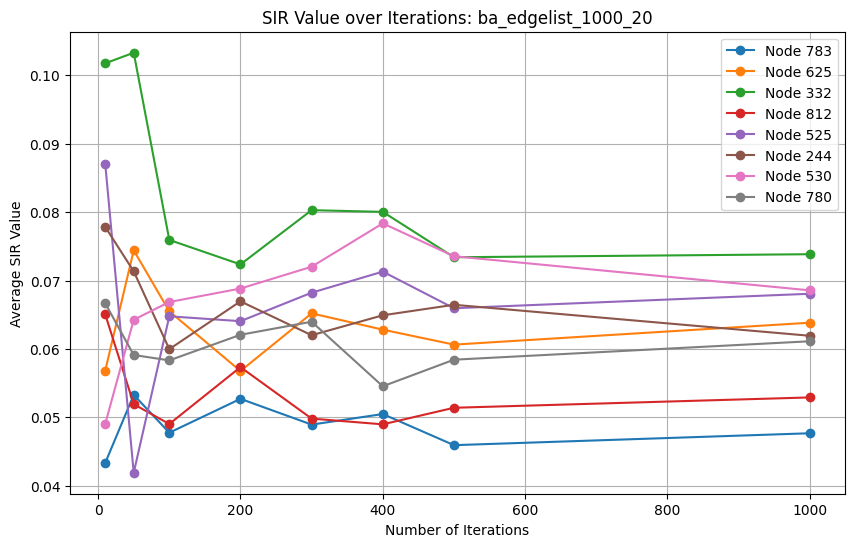

Execution times for ba_edgelist_1000_20 saved to all_execution_times.json
Processing ba_edgelist_1000_4...
Selected nodes: [782, 860, 502, 141, 184, 527, 613, 719]


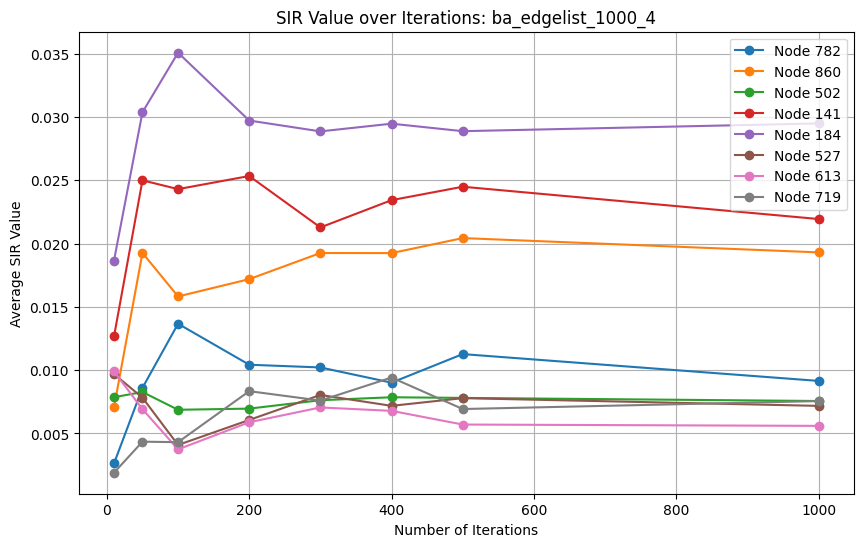

Execution times for ba_edgelist_1000_4 saved to all_execution_times.json
Processing ba_edgelist_2000_10...
Selected nodes: [1395, 729, 1210, 1906, 369, 1590, 51, 1151]


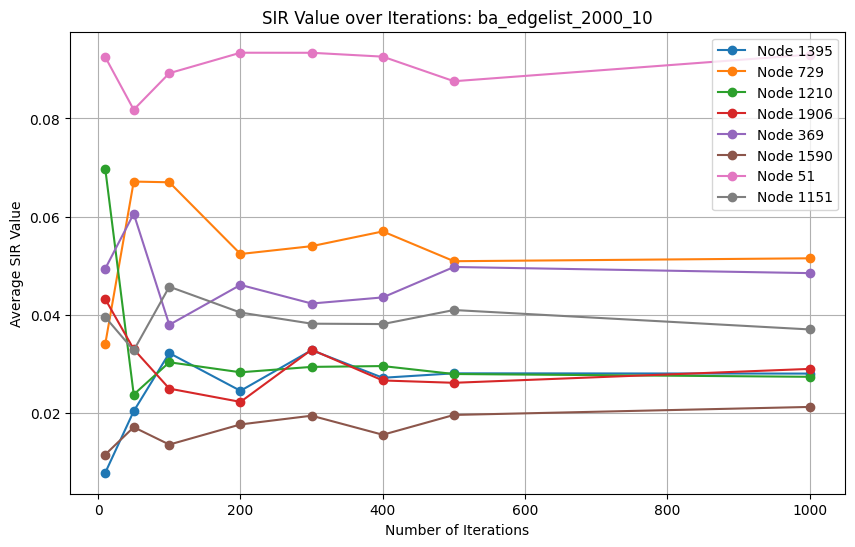

Execution times for ba_edgelist_2000_10 saved to all_execution_times.json
Processing ba_edgelist_2000_20...
Selected nodes: [575, 1369, 1344, 1464, 82, 1353, 316, 1537]


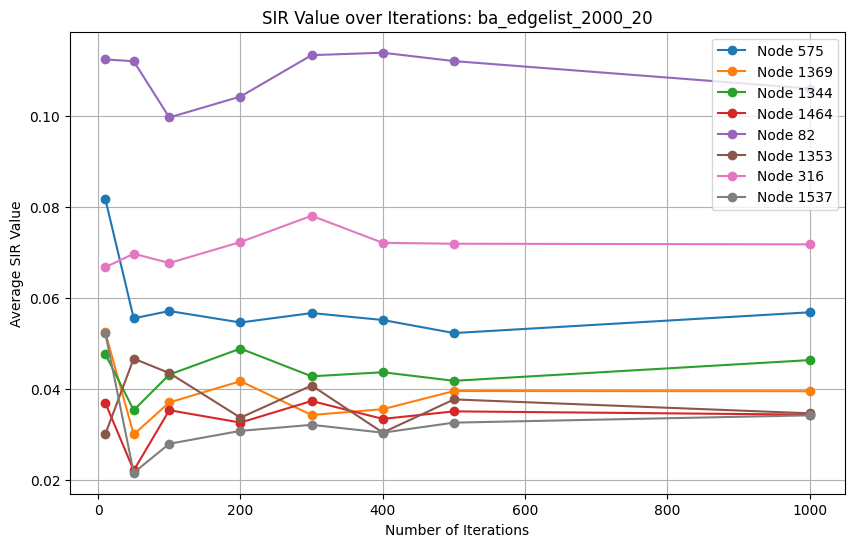

Execution times for ba_edgelist_2000_20 saved to all_execution_times.json
Processing ba_edgelist_2000_4...
Selected nodes: [265, 941, 711, 867, 1536, 1484, 986, 1499]


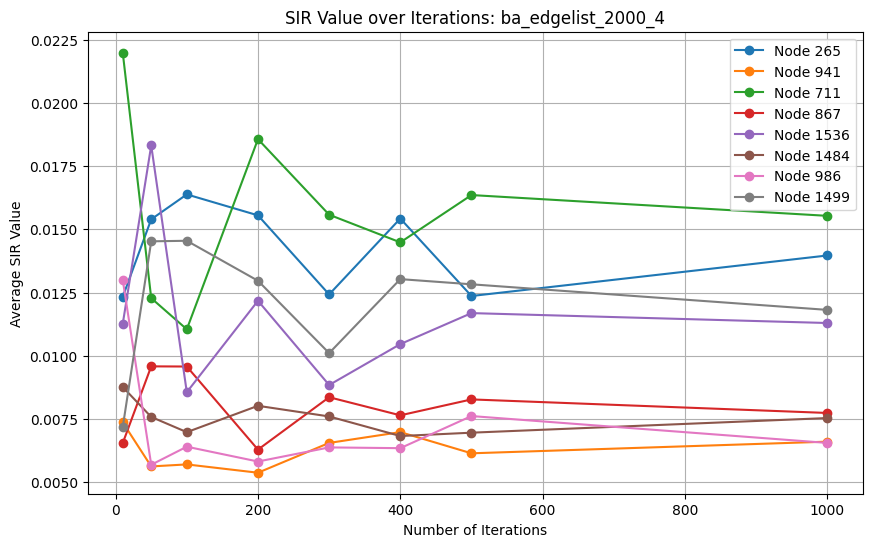

Execution times for ba_edgelist_2000_4 saved to all_execution_times.json
Processing ba_edgelist_3000_10...
Selected nodes: [2934, 1872, 1185, 1567, 38, 173, 566, 646]


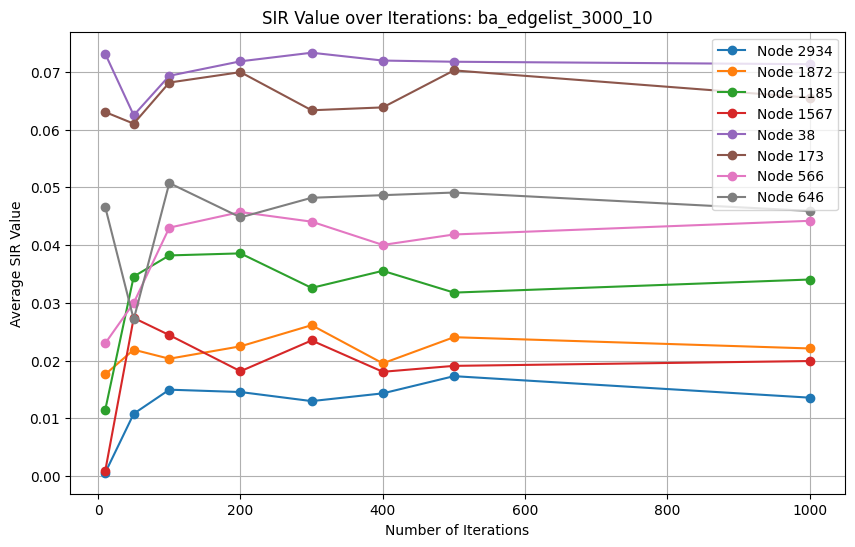

Execution times for ba_edgelist_3000_10 saved to all_execution_times.json
Processing ba_edgelist_3000_20...
Selected nodes: [2583, 2858, 1449, 191, 1304, 771, 2386, 1175]


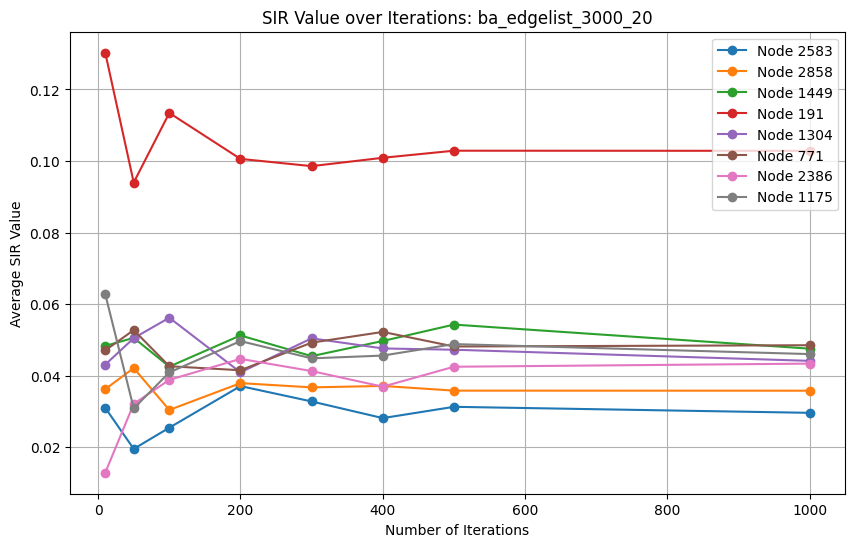

Execution times for ba_edgelist_3000_20 saved to all_execution_times.json
Processing ba_edgelist_3000_4...
Selected nodes: [2531, 2415, 128, 2070, 469, 375, 2614, 2134]


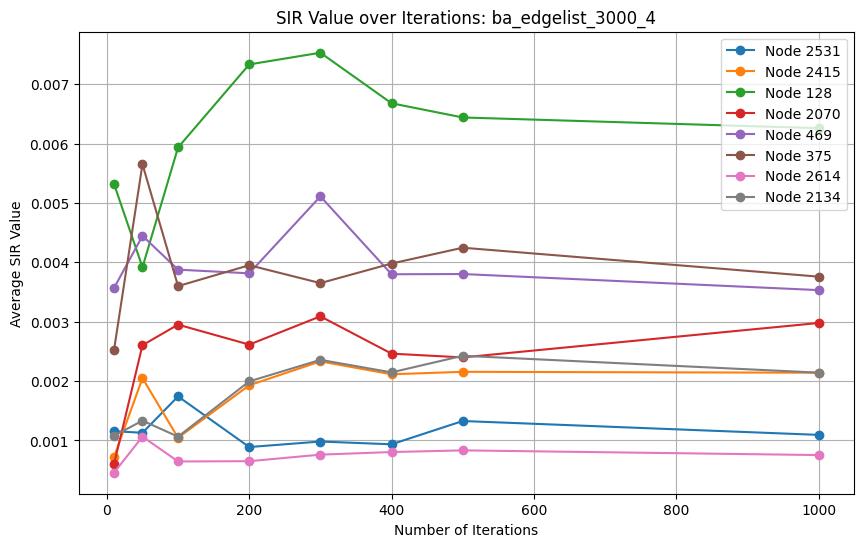

Execution times for ba_edgelist_3000_4 saved to all_execution_times.json
Processing ba_edgelist_exp1_3000_4...
Selected nodes: [600, 2812, 657, 2396, 2881, 538, 2219, 60]


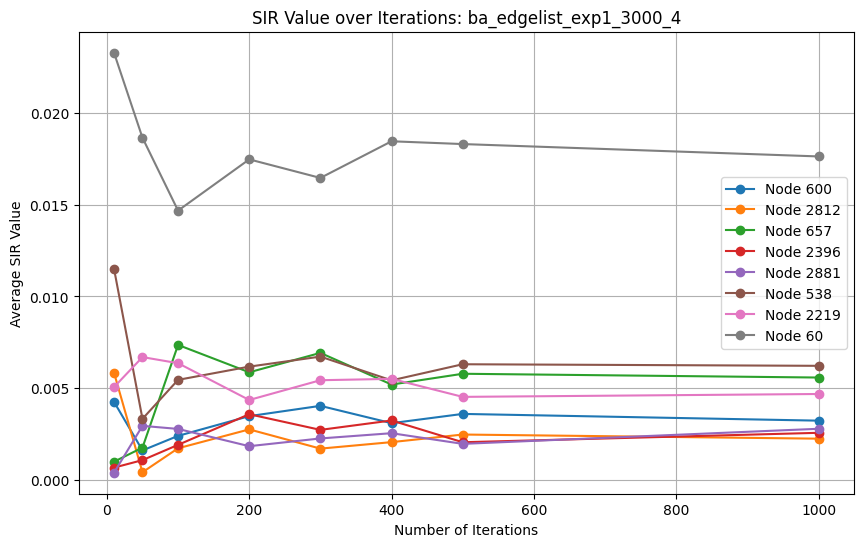

Execution times for ba_edgelist_exp1_3000_4 saved to all_execution_times.json
Processing ba_edgelist_exp1_4000_4...
Selected nodes: [749, 1454, 1235, 3461, 2362, 3814, 1025, 1179]


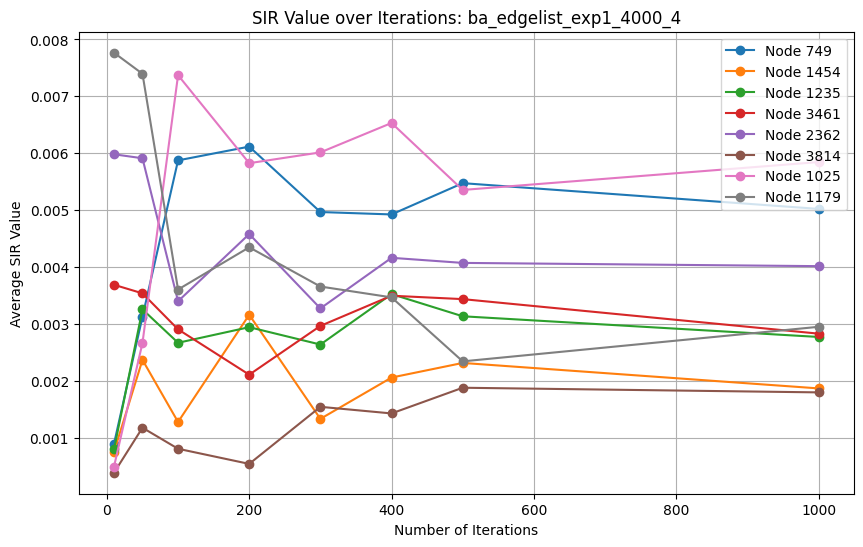

Execution times for ba_edgelist_exp1_4000_4 saved to all_execution_times.json
Processing ba_edgelist_exp1_5000_4...
Selected nodes: [4104, 462, 2365, 949, 2214, 2617, 3969, 2081]


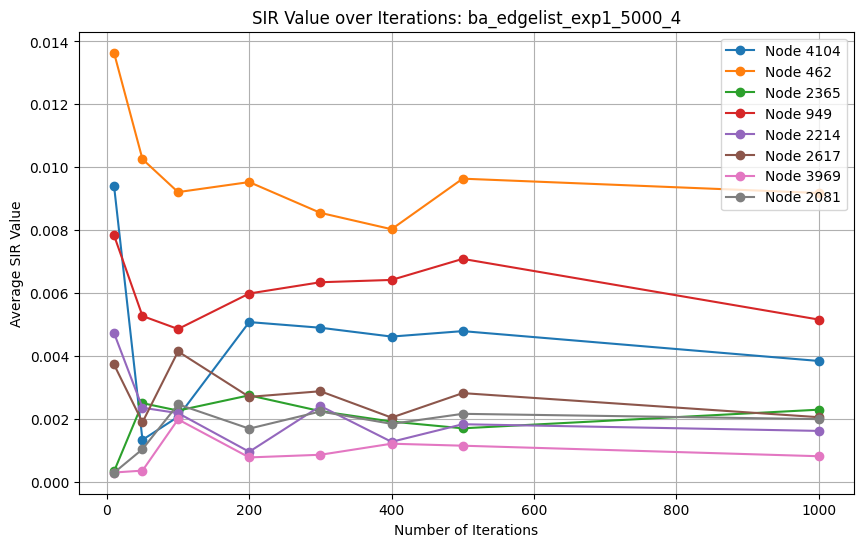

Execution times for ba_edgelist_exp1_5000_4 saved to all_execution_times.json
Processing ba_edgelist_exp1_6000_4...
Selected nodes: [914, 4335, 1537, 2304, 4298, 1936, 3345, 5898]


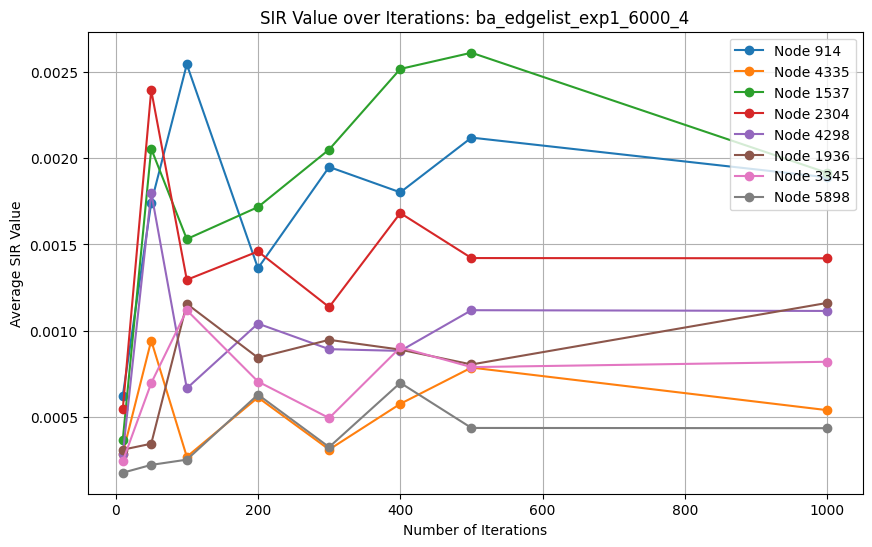

Execution times for ba_edgelist_exp1_6000_4 saved to all_execution_times.json
Processing ba_edgelist_exp1_7000_4...
Selected nodes: [516, 6767, 6828, 1433, 6026, 999, 352, 5244]


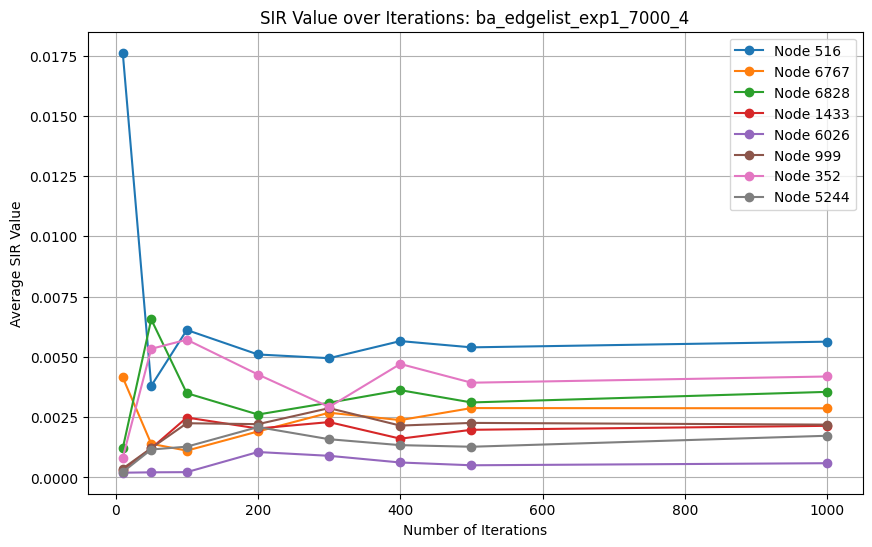

Execution times for ba_edgelist_exp1_7000_4 saved to all_execution_times.json
Processing ba_edgelist_exp1_8000_4...
Selected nodes: [6630, 2564, 4695, 4457, 1594, 4374, 6878, 7004]


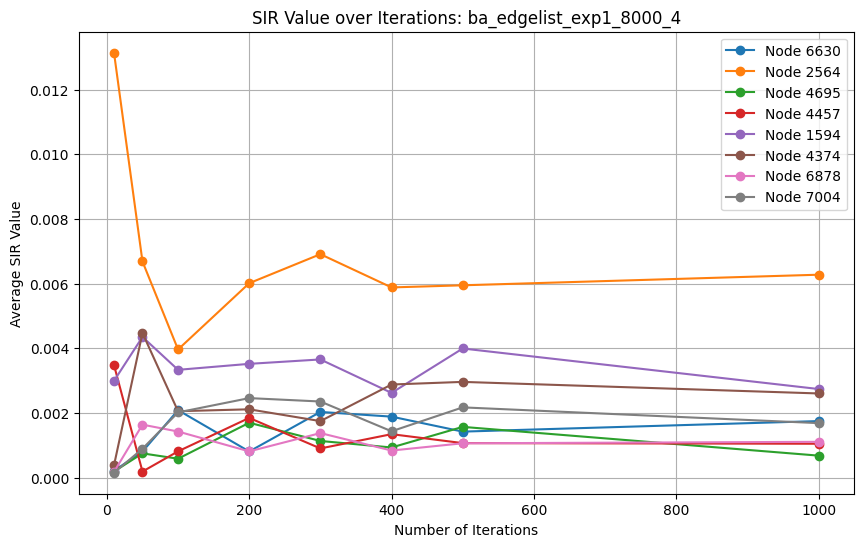

Execution times for ba_edgelist_exp1_8000_4 saved to all_execution_times.json
Processing ba_edgelist_exp2_2000_10...
Selected nodes: [852, 981, 76, 571, 477, 1212, 1316, 1729]


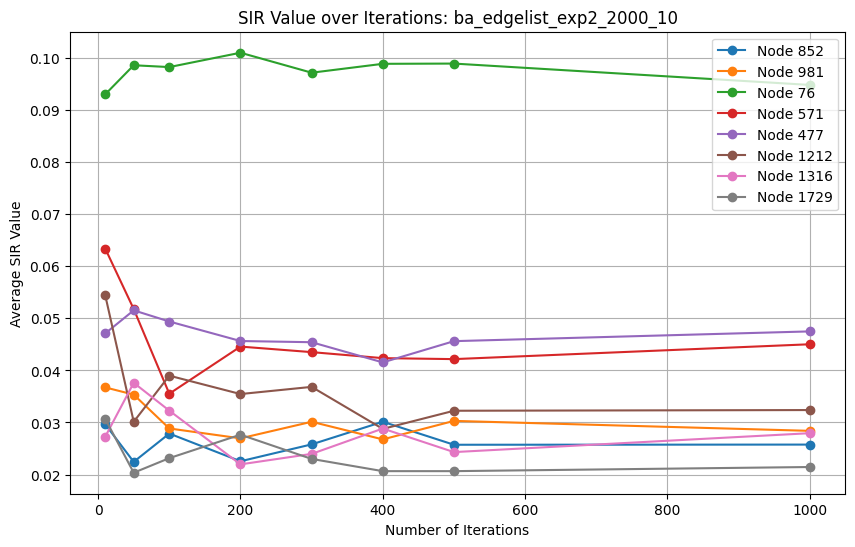

Execution times for ba_edgelist_exp2_2000_10 saved to all_execution_times.json
Processing ba_edgelist_exp2_2000_20...
Selected nodes: [1517, 1002, 1135, 50, 808, 412, 793, 562]


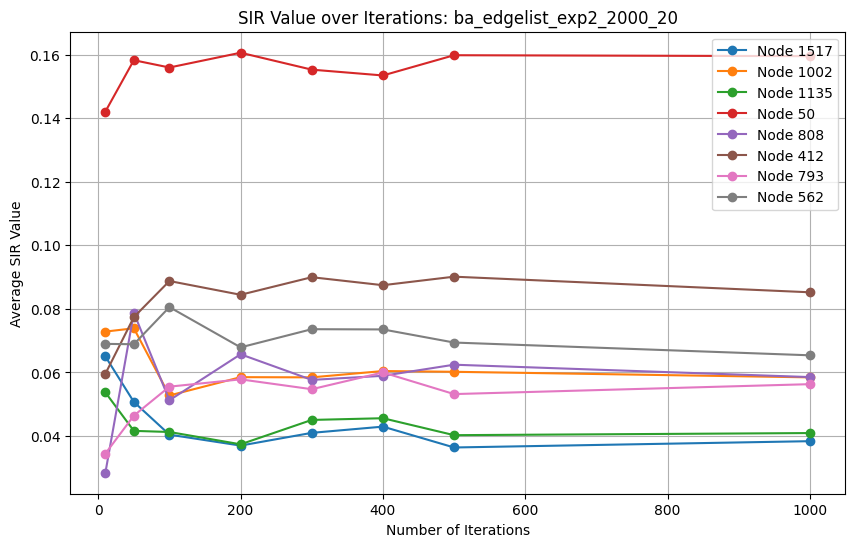

Execution times for ba_edgelist_exp2_2000_20 saved to all_execution_times.json
Processing ba_edgelist_exp2_2000_4...
Selected nodes: [290, 1846, 801, 1926, 1469, 1834, 996, 1778]


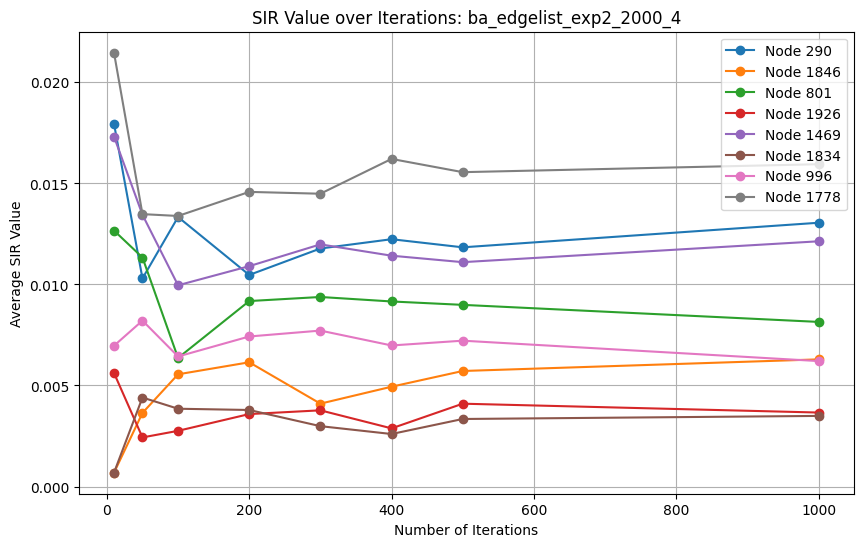

Execution times for ba_edgelist_exp2_2000_4 saved to all_execution_times.json
Processing ba_edgelist_exp3_4000_10...
Selected nodes: [348, 2863, 3157, 1038, 3032, 3216, 3432, 3313]


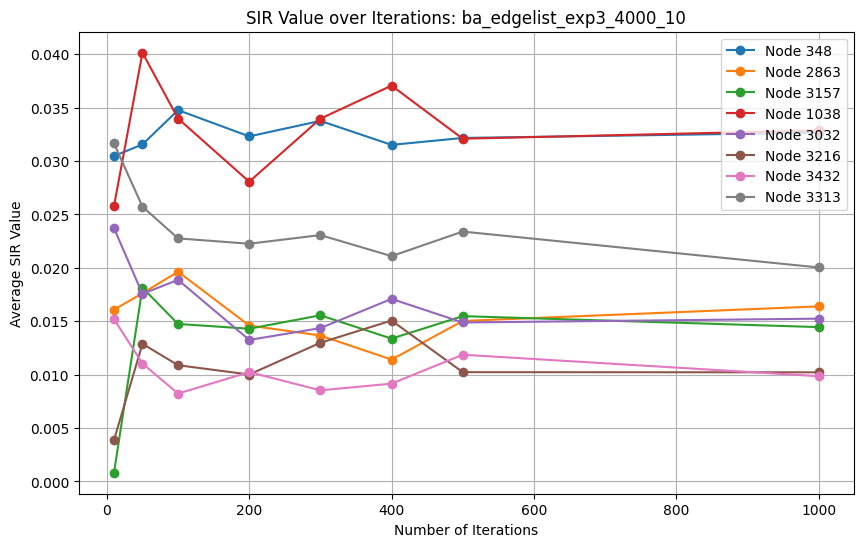

Execution times for ba_edgelist_exp3_4000_10 saved to all_execution_times.json
Processing ba_edgelist_exp3_4000_2...
Selected nodes: [2818, 3479, 3237, 3220, 3416, 1099, 1745, 1056]


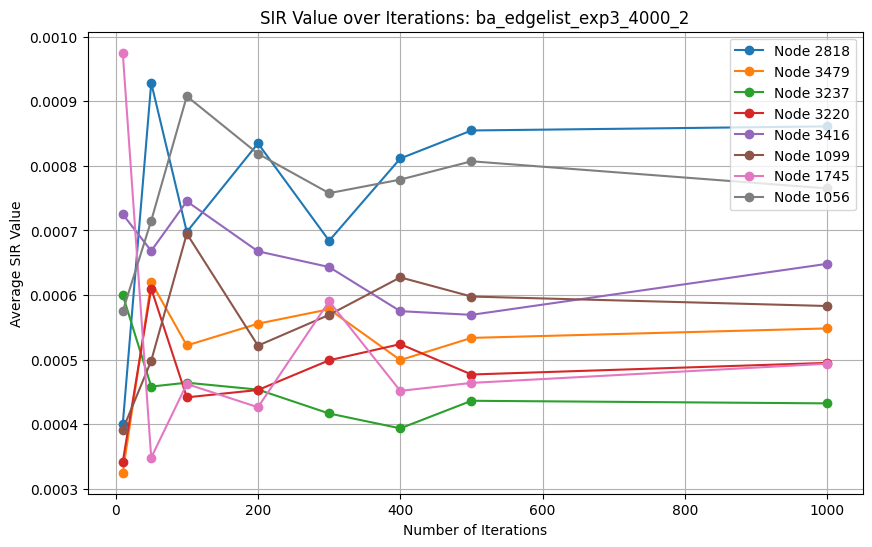

Execution times for ba_edgelist_exp3_4000_2 saved to all_execution_times.json
Processing ba_edgelist_exp3_4000_6...
Selected nodes: [227, 619, 2187, 1284, 955, 2470, 1882, 2447]


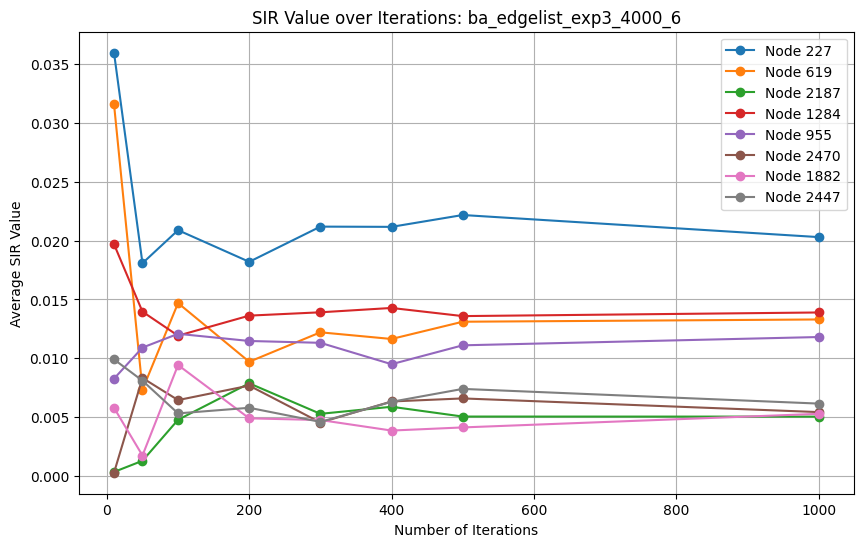

Execution times for ba_edgelist_exp3_4000_6 saved to all_execution_times.json
Processing arenas-pgp...
Selected nodes: [8871, 5949, 9099, 8859, 10092, 10051, 1858, 9414]


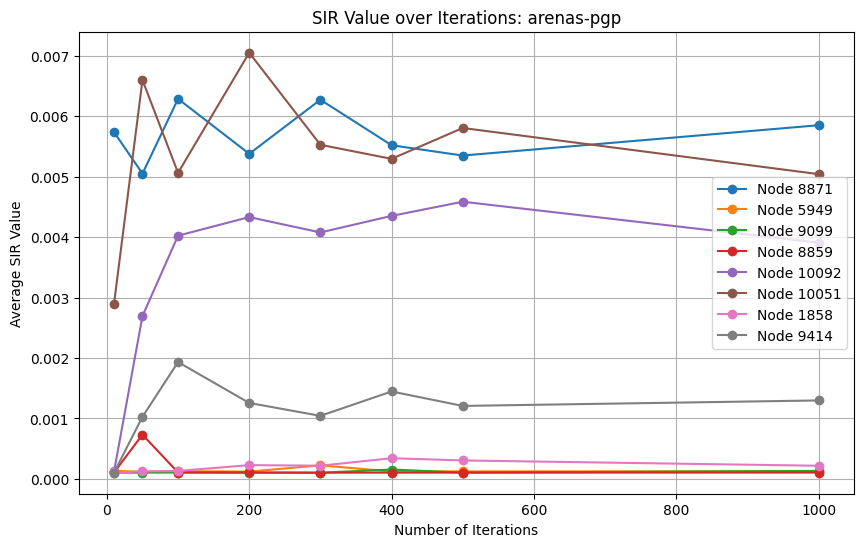

Execution times for arenas-pgp saved to all_execution_times.json
Processing CA-GrQc...
Selected nodes: [12266, 4272, 2915, 938, 11801, 19583, 8184, 2556]


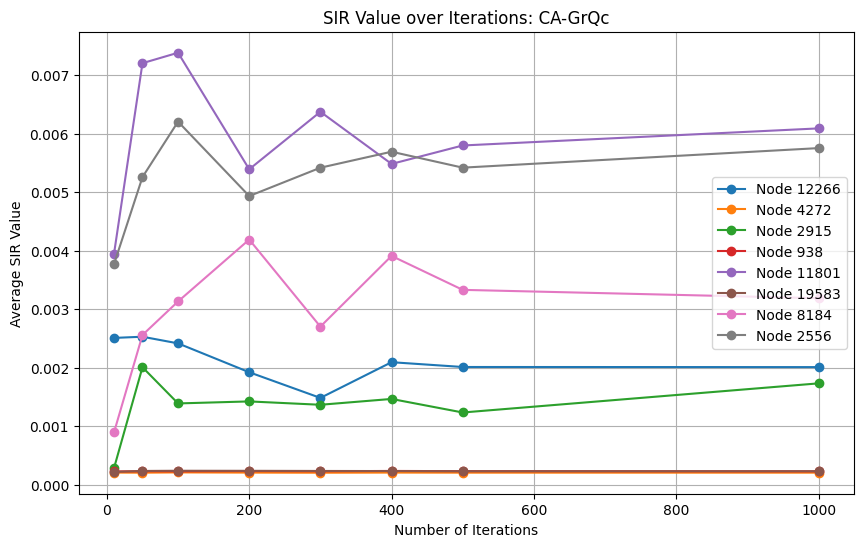

Execution times for CA-GrQc saved to all_execution_times.json
Processing CA-HepTh...
Selected nodes: [61178, 31296, 49517, 35652, 28001, 55838, 51189, 64921]


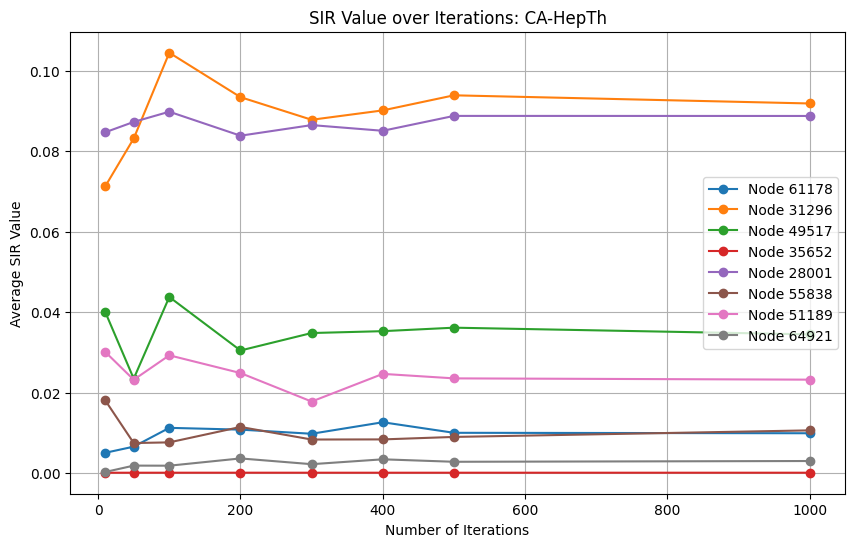

Execution times for CA-HepTh saved to all_execution_times.json
Processing ChicagoRegional...
Selected nodes: [8943, 7980, 12060, 2894, 12874, 3961, 7587, 11769]


In [ ]:
import os
import json

# File path for execution times
execution_times_file = "all_execution_times.json"

# Load execution times if the file exists
if os.path.exists(execution_times_file):
    with open(execution_times_file, "r") as f:
        all_execution_times = json.load(f)
else:
    all_execution_times = {}

graph_list = get_graph_paths()

# Example usage
for graph in graph_list:
    G_path = graph[0]
    net_name = graph[1]

    # Skip graphs that are already in all_execution_times
    if net_name in all_execution_times:
        print(f"Skipping {net_name}, already processed.")
        continue

    print(f"Processing {net_name}...")
    
    G = nx.read_edgelist(G_path, comments="%", nodetype=int)
    
    # Choose 8 random nodes
    infected_nodes = [choose_random_node(G) for _ in range(8)]
    print("Selected nodes:", infected_nodes)

    B_values = get_B_Value(G)
    gama = 1.0
    num_iterations_list = [10, 50, 100, 200, 300, 400, 500, 1000]

    # Analyze and get average execution times
    avg_execution_times = analyze_sir_vs_iterations(net_name, G, infected_nodes, B_values, gama, num_iterations_list)

    # Add to the overall execution times
    all_execution_times[net_name] = avg_execution_times

    # Save execution times to JSON after each graph is processed
    with open(execution_times_file, "w") as json_file:
        json.dump(all_execution_times, json_file, indent=4)
        print(f"Execution times for {net_name} saved to {execution_times_file}")


   
`num_iterations_list = [10, 50, 100, 200, 300, 400, 500, 1000]   
`    

- you may wonder why i removed the 1000 element of the list, honey running this simulation took 2 minutes and 15 seconds for the smallest of my graphs